In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [3]:
map_dir='/tigress/zequnl/cmb/data/planck/maps/PR2/frequencyMaps'
mask_dir='/tigress/zequnl/cmb/data/planck/maps/PR2/maskMaps/'

In [4]:
f0, f1 = '143', '143'
split0, split1 = '1', '2'

lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

I wrote this awful function to test the low ell binning, it has very minor effects and I should just add the bins manually. It basically adds the bins 2-30 with some width.

In [5]:
binleft, binright = np.arange(2,lmax+1), np.arange(2,lmax+1)
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 / np.sum(bpws == bpws[l]) for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

In [6]:
beam_filename = f'planck_beam/beam_likelihood_{f0}hm1x{f1}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

/home/zequnl/.local/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/zequnl/.local/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


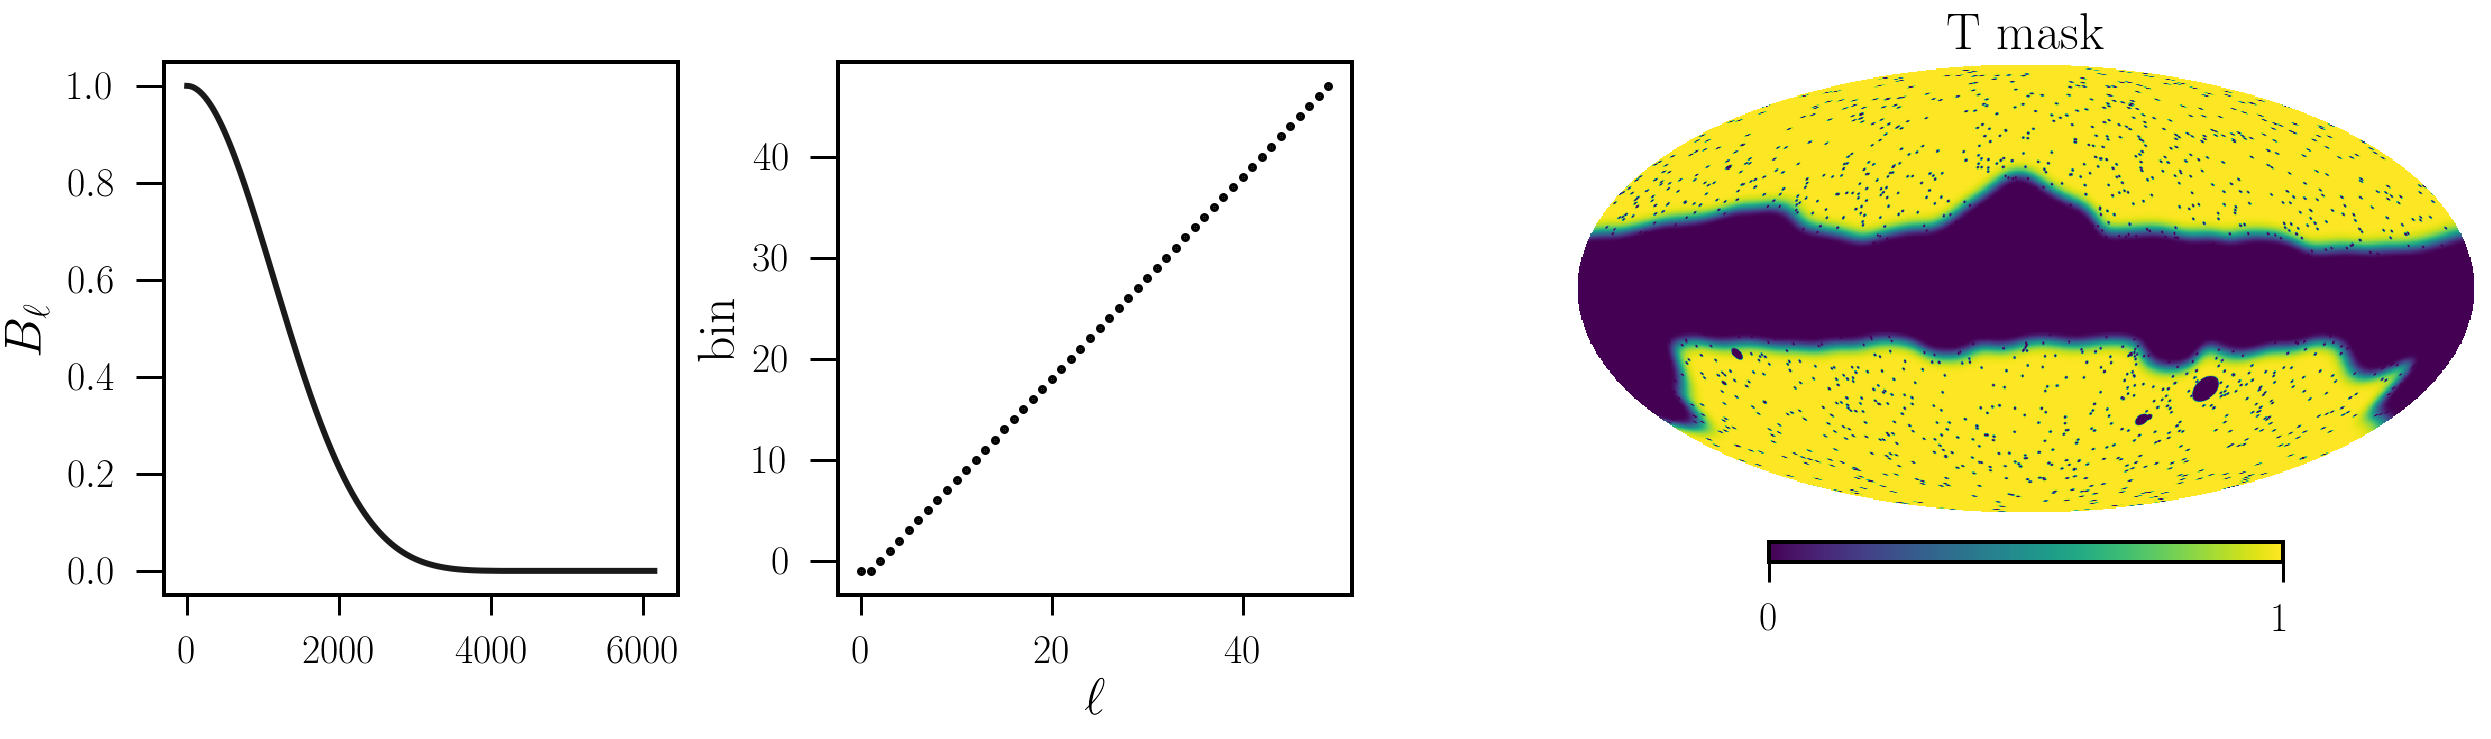

In [7]:
mask0t = hp.read_map(f'{mask_dir}/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask0p = hp.read_map(f'{mask_dir}/COM_Mask_Likelihood-polarization-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'{mask_dir}/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)
mask1p = hp.read_map(f'{mask_dir}/COM_Mask_Likelihood-polarization-{f1}_2048_R2.00.fits', verbose=False)

mask0 = [mask0t, mask0p, mask0p]
mask1 = [mask1t, mask1p, mask1p]

fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws[:50], 'k.')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

In [8]:
m0_file = f'{map_dir}/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
m1_file = f'{map_dir}/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'

map0 = [hp.read_map(m0_file, field=0, verbose=False), # I
        hp.read_map(m0_file, field=1, verbose=False), # Q
        hp.read_map(m0_file, field=2, verbose=False)] # U
map1 = [hp.read_map(m1_file, field=0, verbose=False), # I
        hp.read_map(m1_file, field=1, verbose=False), # Q
        hp.read_map(m1_file, field=2, verbose=False)] # U

/home/zequnl/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


I currently compute the bad pixels from the map `II_COV`, `QQ_COV`, `UU_COV`, looking for the healpix missing pixel value.

In [9]:
def load_bad_pix(freq, split):
    mfile = f'{map_dir}/HFI_SkyMap_{freq}_2048_R2.02_halfmission-{split}.fits'
    II_COV = hp.read_map(mfile, field=4, verbose=False)
    QQ_COV = hp.read_map(mfile, field=5, verbose=False)
    UU_COV = hp.read_map(mfile, field=6, verbose=False)

    badT = II_COV < -1e30
    print( 'bad pixels II == QQ?', np.all(badT == (QQ_COV < -1e30)), 
          ', bad pixels II == UU?', np.all(badT == (UU_COV < -1e30)) )
    return (badT, badT, badT)

badpix0 = load_bad_pix(f0, split0)
badpix1 = load_bad_pix(f1, split1)

map0 = [ (~bp).astype(float) * m for m, bp in zip(map0, badpix0) ]
map1 = [ (~bp).astype(float) * m for m, bp in zip(map1, badpix1) ]

bad pixels II == QQ? True , bad pixels II == UU? True
bad pixels II == QQ? True , bad pixels II == UU? True


We discovered it was important to subtract the monopole to get the temperature power spectrum right.

In [10]:
def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
        m.flat[ipix] -= dipole[0] * x
        m.flat[ipix] -= dipole[1] * y
        m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
    return m

# subtract from temperature
map0[0] = subtract_mono_di(map0[0], mask0[0])
map1[0] = subtract_mono_di(map1[0], mask1[0])

# map0 = [subtract_mono_di(m, mask)
#     for m, mask in zip(map0, mask0)]
# map1 = [subtract_mono_di(m, mask)
#     for m, mask in zip(map1, mask1)]

In [11]:
pixel_window_T, pixel_window_P = hp.sphtfunc.pixwin(nside, pol=True)[:len(Bl)]

In [12]:
niter = 0

f0t = nmt.NmtField(mask0t, [map0[0]], beam=(Bl*pixel_window_T), n_iter=niter)
f1t = nmt.NmtField(mask0t, [map1[0]], beam=(Bl*pixel_window_T), n_iter=niter)

f0p = nmt.NmtField(mask0p,[map0[1], map0[2]], beam=(Bl*pixel_window_P), n_iter=niter)
f1p = nmt.NmtField(mask1p,[map1[1], map1[2]], beam=(Bl*pixel_window_P), n_iter=niter)

w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(f0t,f1t, b, n_iter=niter)
w1=nmt.NmtWorkspace()
w1.compute_coupling_matrix(f0t,f1p, b, n_iter=niter)
w2=nmt.NmtWorkspace()
w2.compute_coupling_matrix(f0p,f1p, b, n_iter=niter)

def compute_master(f_a,f_b,wsp) :
    cl_coupled=nmt.compute_coupled_cell(f_a,f_b)
    cl_decoupled=wsp.decouple_cell(cl_coupled)
    return cl_decoupled


In [13]:
Cb_namaster={}
Cb_namaster['TT']=compute_master(f0t,f1t,w0)[0]
spin1=compute_master(f0t,f1p,w1)
Cb_namaster['TE']=spin1[0]
Cb_namaster['TB']=spin1[1]
Cb_namaster['ET']=Cb_namaster['TE']
Cb_namaster['BT']=Cb_namaster['TB']
spin2=compute_master(f0p,f1p,w2)
Cb_namaster['EE']=spin2[0]
Cb_namaster['EB']=spin2[1]
Cb_namaster['BE']=spin2[2]
Cb_namaster['BB']=spin2[3]

In [14]:
Cb_namaster2={}

spin1=compute_master(f1t,f0p,w1)
Cb_namaster2['TE']=spin1[0]
Cb_namaster2['TB']=spin1[1]
Cb_namaster2['ET']=Cb_namaster2['TE']
Cb_namaster2['BT']=Cb_namaster2['TB']


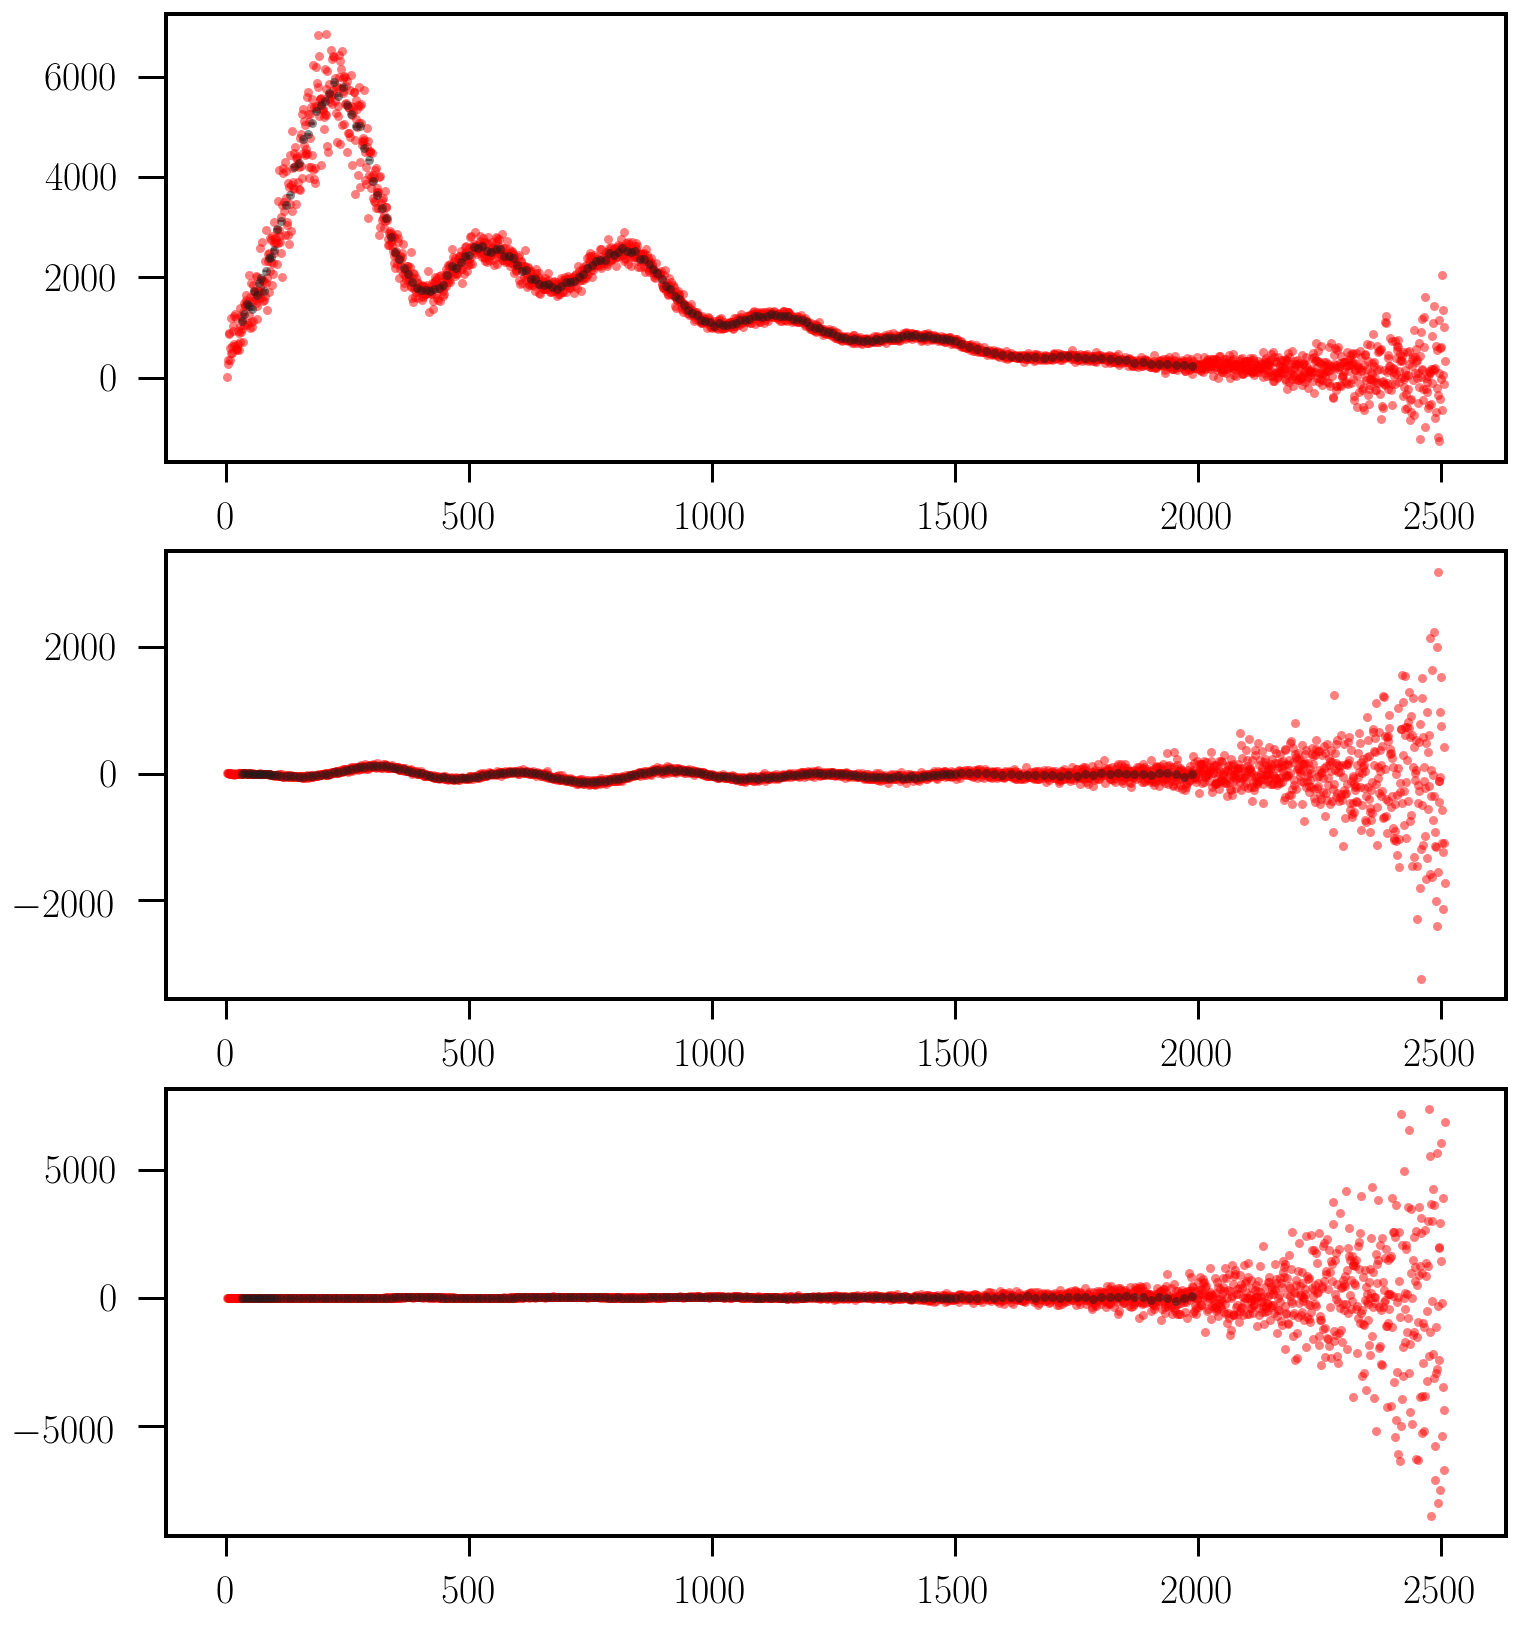

In [15]:
fig, axes = plt.subplots(3,1,figsize=(12,14))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)
  
    ax.errorbar(l_ref,cl_ref*dl_ref_fac,
                error_ref*dl_ref_fac,
                fmt='.',label='%s'%f'{spec}_{f0}x{f1}', alpha=0.5)
    Cb = Cb_namaster[spec]*1e12
    if spec == 'TE':
        Cb = (Cb_namaster[spec] + Cb_namaster2[spec])*1e12 / 2
    ax.plot(lb, Cb * lb**2 / 2 /np.pi,'r.',label=r"NaMaster", alpha=0.5)

In [29]:
class planck_binner:
    def __init__(self, lmax):
        self.lmax = lmax
        self.ll = np.arange(lmax-1)

    def bin_spec(self, s):
        binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
        ell_sub_list = [ np.arange(l,r) for (l,r) in zip(binleft, binright+1) ]
        self.lb = np.array([np.sum(ell_sub) / len(ell_sub) for ell_sub in ell_sub_list])
        cl_from_zero = np.zeros(self.lmax+1)
        cl_from_zero[self.ll.astype('int')] = s * 1e12
        weights = np.arange(self.lmax+1) * (np.arange(self.lmax+1) + 1)
        return np.array([np.sum((weights * cl_from_zero)[ell_sub]
                      ) / np.sum(weights[ell_sub]) for ell_sub in ell_sub_list])
        
    def bin_spec_dict(self, Cb):
        result = {}
        for spec_key in Cb:
            result[spec_key] = self.bin_spec(Cb[spec_key])
            
        return self.lb, result
    

In [32]:
lb, Cb = planck_binner(lmax=lmax).bin_spec_dict(Cb=Cb_namaster)

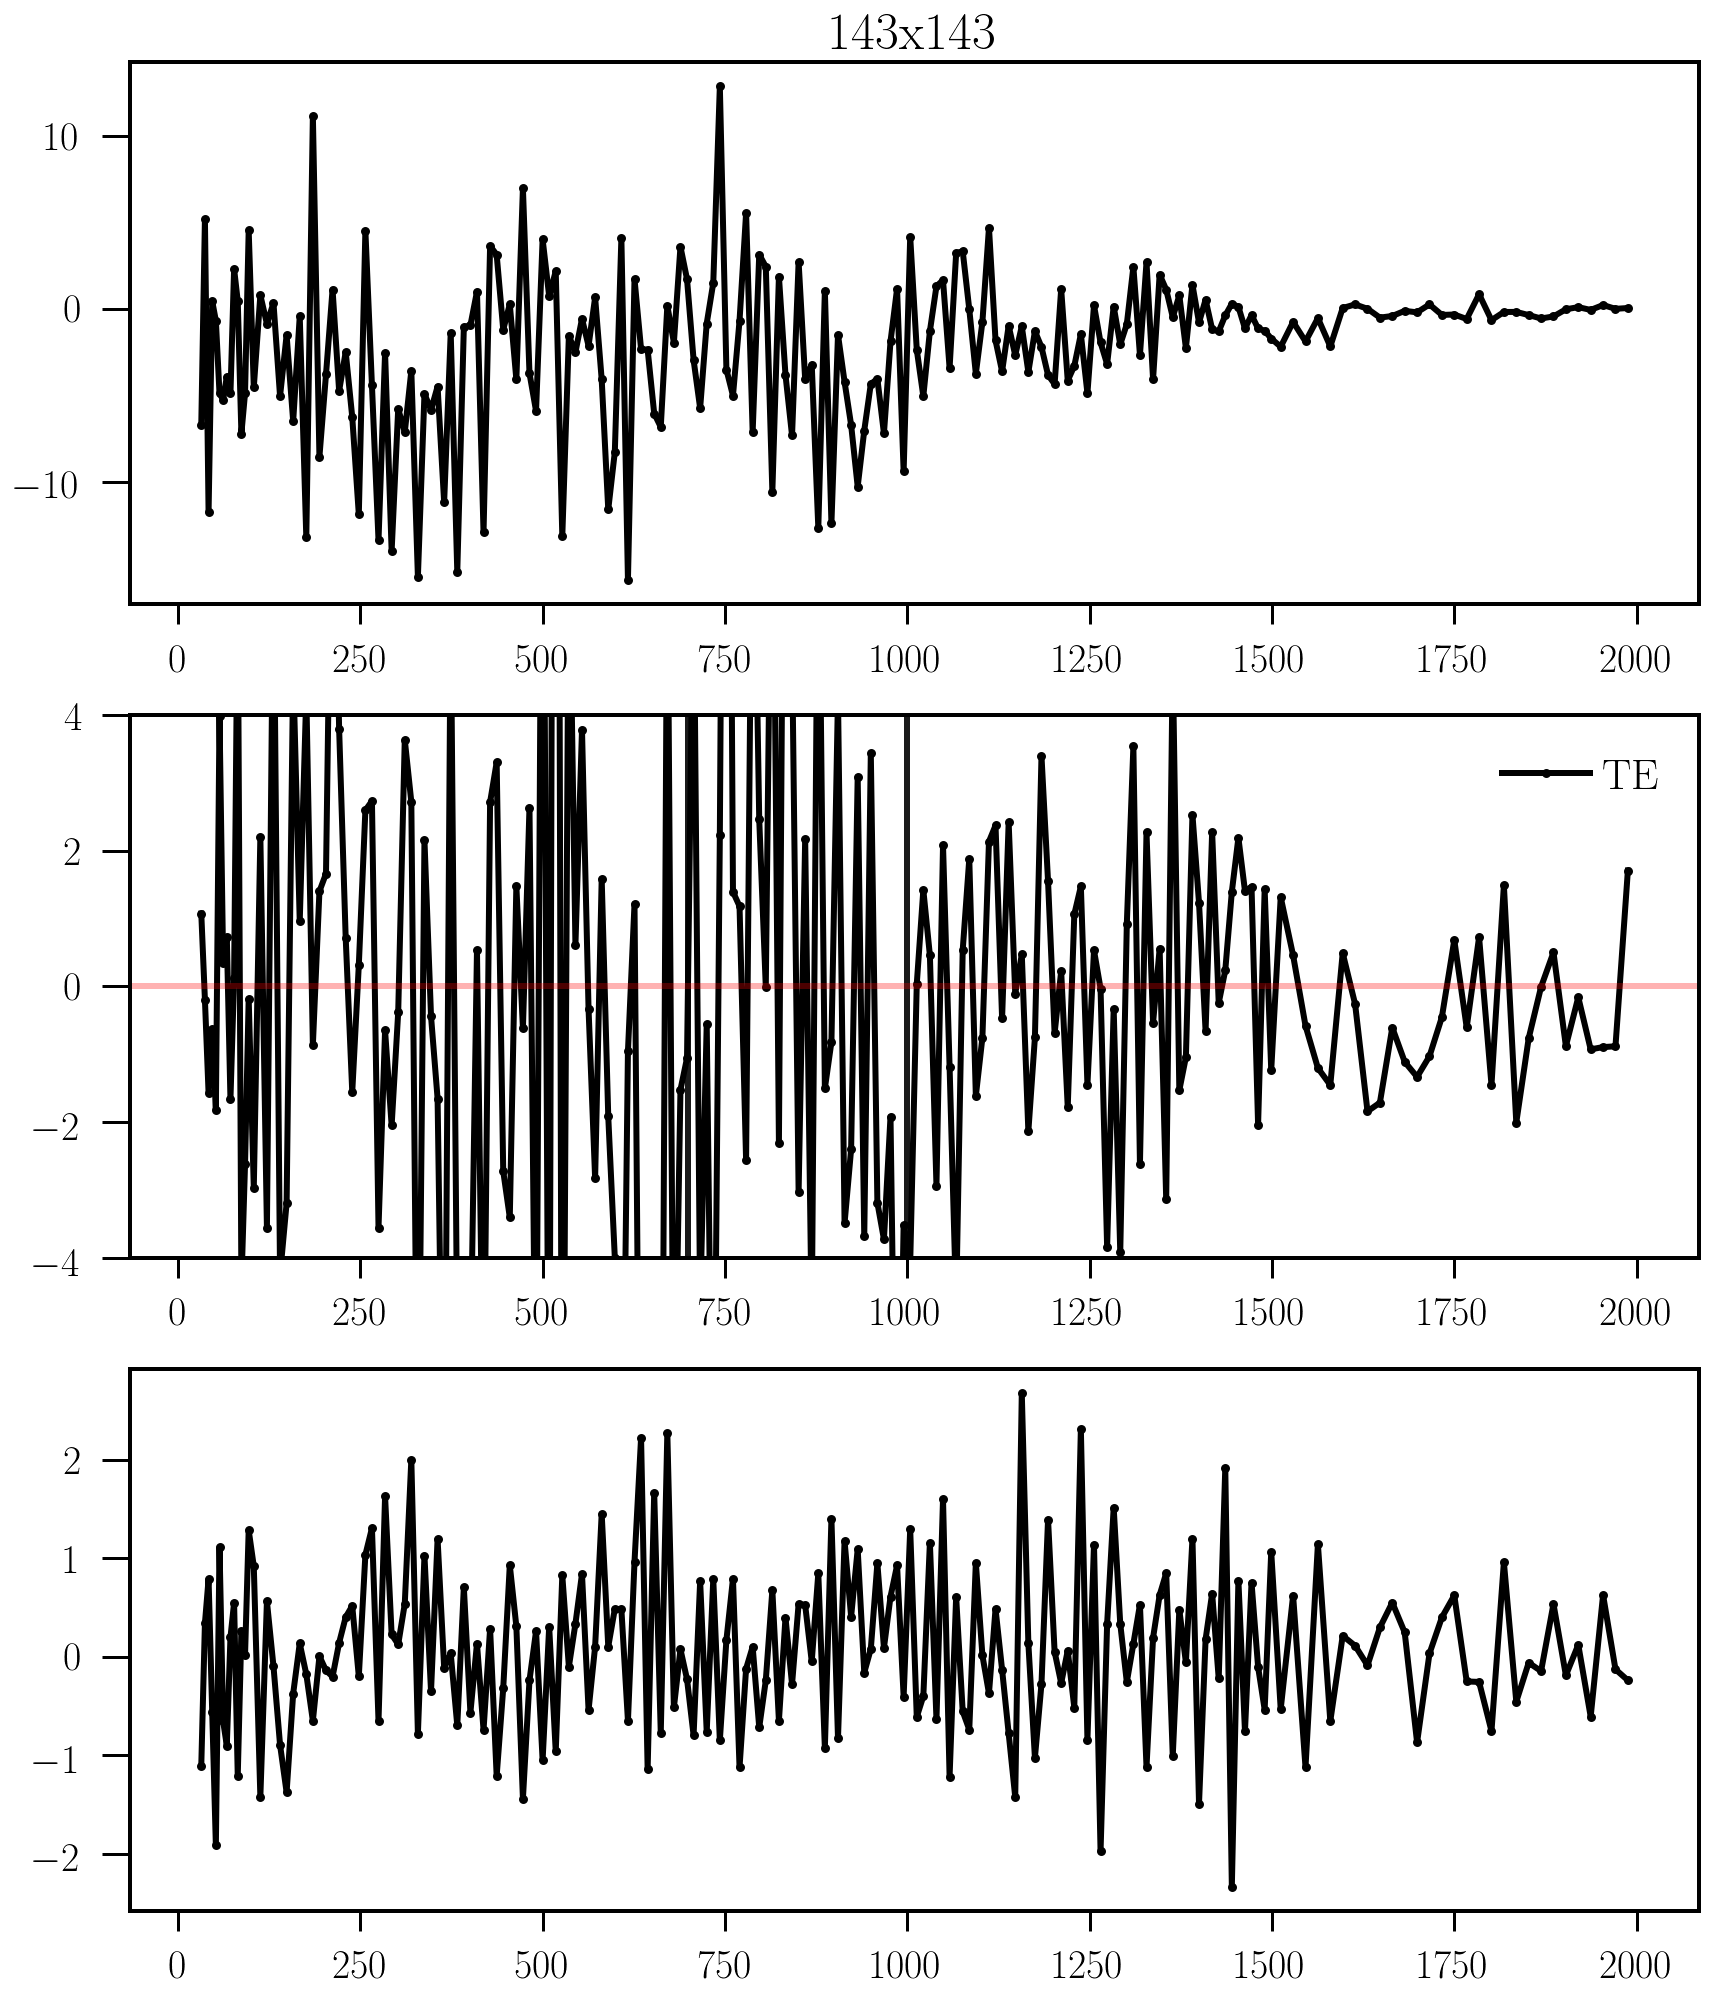

In [38]:
fig, axes = plt.subplots(3,1,figsize=(12,14))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)
    
#     lb, Cb1 = ps.bin_spec_dict(ps.Cb1) 
#     if spec == 'TE':
#         lb, Cb2 = ps.bin_spec_dict(ps.Cb2) 
#         s = (Cb1[spec] + Cb2[spec]) / 2
#     else:
#         s = Cb1[spec]

    if spec != 'TE':
        lb, Cb1 = planck_binner(lmax=lmax).bin_spec_dict(Cb=Cb_namaster)
        s = Cb1[spec]
        ref_filt = np.in1d(lb, l_ref)
        ax.plot(l_ref, (s[ref_filt] - (cl_ref)) / (error_ref), 
                'k.-', label=spec)
        
    else:
        lb, Cb1 = planck_binner(lmax=lmax).bin_spec_dict(Cb=Cb_namaster)
        lb, Cb2 = planck_binner(lmax=lmax).bin_spec_dict(Cb=Cb_namaster)
#         s = (Cb1 + Cb2)/2.0
        ax.axvline(700)
        ax.axvline(1000)
        ref_filt = np.in1d(lb, l_ref)
        ax.plot(l_ref, ( (Cb1[spec]+Cb2[spec])[ref_filt]/2.0 - (cl_ref)) / (error_ref), 
                'k.-', label=spec)

        ax.axhline(0, color='red', alpha=0.3)
        ax.set_ylim(-4,4)
        ax.legend()
    
axes[0].set_title(f'{f0}x{f1}')

plt.tight_layout()